In [2]:
%load_ext autoreload
%autoreload 2

### Импорты

In [3]:
import sys
sys.path.append('..')
from control_variates.model import MLP
from control_variates.optim import LangevinSGD as SGLD, ScaleAdaSGHMC as H_SA_SGHMC
from mnist_utils import load_mnist_dataset
from control_variates.trainer import BNNTrainer
import torch
from torch.nn import functional as F

import numpy as np
import dill as pickle
from pathlib import Path
from functools import partial
from easydict import EasyDict as edict

%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

### Параметры обучения

In [62]:
# psy_hidden = 150
# psy_depth1 = 3
# psy_depth2 = 2

args = {
    'bnn_lr': 1e-3,
    'cv_lr': 1e-3,
    'n_cv_iter': 100,
    'batch_size' : 500,
    'input_dim' : 784,
    'width' : 100,
    'depth' : 2,
    'output_dim' : 2,
    'n_epoch' : 200,
    'alpha0' : 10, 
    'beta0' : 10,
    'resample_prior_every' : 15,
    'resample_momentum_every' : 50,
    'burn_in_epochs' : 20,
    'save_freq' : 4,
    'resample_prior_until' : 100,
    'report_every' : 10,
    }

args = edict(args)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Берем два класса из МНИСТа

In [6]:
Path('../data', 'mnist').mkdir(exist_ok=True, parents=True)
trainloader, valloader = load_mnist_dataset(Path('../data', 'mnist'), args.batch_size, [3, 5])

In [7]:
#model = MLP(input_dim=input_dim, width=width, depth=depth, output_dim=output_dim)

In [8]:
from control_variates.model import LogRegression
model = LogRegression(args.input_dim)

In [9]:
#optimizer = SGLD(model.parameters(), lr=lr, alpha0=alpha0, beta0=beta0)
optimizer = H_SA_SGHMC(model.parameters(), lr=args.bnn_lr, alpha0=args.alpha0, beta0=args.beta0)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=False)

In [10]:
def nll_func(y_hat, y):
    nll = F.cross_entropy(y_hat, y, reduction='sum')
    return nll

def err_func(y_hat, y):
    err = y_hat.argmax(-1).ne(y)
    return err

In [11]:
trainer = BNNTrainer(model, 
    optimizer, 
    nll_func, 
    err_func, 
    trainloader, 
    valloader, 
    device=device, 
    resample_prior_every=args.resample_prior_every,
    resample_momentum_every=args.resample_momentum_every,
    save_freq=args.save_freq,
    batch_size=args.batch_size
    )

In [17]:
trainer.train(n_epoch=args.n_epoch, burn_in_epochs=args.burn_in_epochs, resample_prior_until=args.resample_prior_until)

2020-08-15 14:20:21,724 Epoch 0 finished. Val loss 0.802029550075531, Val error 0.5247108307045215
2020-08-15 14:20:46,947 Epoch 10 finished. Val loss 0.5323190689086914, Val error 0.2192429022082019
2020-08-15 14:21:04,992 Epoch 20 finished. Val loss 0.41277220845222473, Val error 0.1440588853838065
2020-08-15 14:21:23,554 Epoch 30 finished. Val loss 0.33310285210609436, Val error 0.1056782334384858
2020-08-15 14:21:40,865 Epoch 40 finished. Val loss 0.2908410429954529, Val error 0.0914826498422713
2020-08-15 14:22:03,856 Epoch 50 finished. Val loss 0.26344412565231323, Val error 0.08201892744479496
2020-08-15 14:22:26,756 Epoch 60 finished. Val loss 0.2436000406742096, Val error 0.07728706624605679
2020-08-15 14:22:48,124 Epoch 70 finished. Val loss 0.22829683125019073, Val error 0.06887486855941115
2020-08-15 14:23:06,016 Epoch 80 finished. Val loss 0.2166004776954651, Val error 0.06782334384858044
2020-08-15 14:23:23,363 Epoch 90 finished. Val loss 0.20697040855884552, Val error 0.

### Сохраняем сэмплы весов

In [18]:
weights_set = trainer.weight_set_samples[-(args.n_epoch - args.resample_prior_until) // args.save_freq:]

print(len(weights_set))

Path('../saved_samples', 'mnist_weights').mkdir(exist_ok=True, parents=True)
pickle.dump(weights_set, Path('../saved_samples', 'mnist_weights', 'weights.pkl').open('wb'))

25


In [63]:
weights_set = pickle.load(Path('../saved_samples', 'mnist_weights', 'weights.pkl').open('rb'))

In [64]:
len(weights_set)

25

### CV

In [65]:
from control_variates.cv_utils import state_dict_to_vec
from control_variates.cv_utils import compute_log_likelihood, compute_mc_estimate, compute_naive_variance, compute_tricky_divergence
from control_variates.model import get_prediction, get_binary_prediction

In [66]:
squeezed_weights = [state_dict_to_vec(w) for w in weights_set]

models = [LogRegression(args.input_dim) for _ in range(len(weights_set))]
for w, model in zip(weights_set, models):
    model.load_state_dict(w)

In [27]:
opt_with_priors = trainer.optimizer

priors = {}
group_params = opt_with_priors.param_groups[0]['params']
for (n, _), p in zip(model.named_parameters(), group_params):  
    state = opt_with_priors.state[p]  
    priors[n] = state['weight_decay']

pickle.dump(priors, Path('../saved_samples', 'mnist_weights', 'priors.pkl').open('wb'))

In [67]:
priors = pickle.load(Path('../saved_samples', 'mnist_weights', 'priors.pkl').open('rb'))

In [68]:
from control_variates.cv import PsyMLP, PsyDoubleMLP, PsyLinear, SteinCV


In [69]:

psy_input_dim = squeezed_weights[0].shape[0]
N_train = len(trainloader.dataset)

In [70]:

_, new_valloader = load_mnist_dataset(Path('../data', 'mnist'), args.batch_size, [4, 4])

In [71]:
x_new, y_new = next(iter(new_valloader))

In [72]:
x_new, y_new = next(iter(valloader))
train_x, train_y = next(iter(trainloader))

### Фитим на батче

In [134]:
#psy_model = PsyMLP(psy_input1, psy_hidden, psy_depth1)
psy_model = PsyLinear(psy_input_dim)
psy_model.init_zero()
psy_model.to(device)

neural_control_variate = SteinCV(psy_model, train_x, train_y, priors, N_train)

ncv_optimizer = torch.optim.Adam(psy_model.parameters(), lr=args.cv_lr)

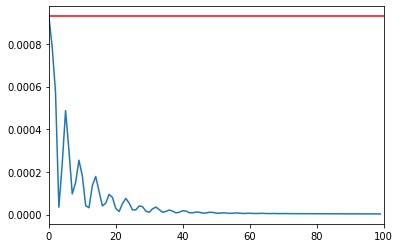

In [135]:
function_f = lambda model, x: get_binary_prediction(model, x, classes=[0, 1])
history = [] #np.zeros()
x = x_new[20:21]
fig = plt.figure()
for it in range(args.n_cv_iter):
    ncv_optimizer.zero_grad()
    mc_variance, no_cv_variance = compute_naive_variance(function_f, neural_control_variate, models, x)
    history.append(mc_variance.sum().item())
    mc_variance.backward()
    ncv_optimizer.step()

plt.plot(np.arange(it+1), history)
plt.axhline(y=no_cv_variance, color='r', linestyle='-')
plt.xlim(0, args.n_cv_iter)
plt.show()

In [137]:
from uncertainty_quantification import ClassificationUncertaintyMCMC

In [138]:
uncertainty_qunt = ClassificationUncertaintyMCMC(models, neural_control_variate)

mean = uncertainty_qunt.estimate_emperical_mean(x_new[20:21])
variance = uncertainty_qunt.estimate_emperical_variance(x_new[20:21])

mean, variance

(tensor(0.9494, grad_fn=<SubBackward0>),
 tensor(0.0009, grad_fn=<DivBackward0>))

In [139]:
uncertainty_qunt = ClassificationUncertaintyMCMC(models, None)

mean = uncertainty_qunt.estimate_emperical_mean(x_new[20:21])
variance = uncertainty_qunt.estimate_emperical_variance(x_new[20:21])

mean, variance

(tensor(1., grad_fn=<SubBackward0>), tensor(0., grad_fn=<DivBackward0>))